In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import sympy as sp

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

In [54]:
m1, m2, m3 = 3.72, 8.0, 68.28
l1, l2 = 0.443, 0.441
a1, a2, a3 = 0.221, 0.221, 0.447
I1, I2, I3 = 0.0608, 0.1297, 5.179
g = 9.81

B1 = m1*a1**2 + I1 + m2*l1**2 + m3*l1**2
B2 = m2*a2**2 + I2 + m3*l2**2
B3 = m2*a2*l1 + m3*l1*l2
B4 = m3*a3**2 + I3
B5 = m3*a3*l1
B6 = m3*a3*l2

D1 = -m1*g*a1 - m2*g*l1 - m3*g*l1
D2 = m2*g*a2 + m3*g*l2
D3 = m3*g*a3
D5 = -m2*a2*l1 + m3*l1*l2

In [6]:
def M(q1, q2, q3):
  M11 = B1 + B2 + 2*B3*np.cos(q2) + 2*B5*np.cos(q2 - q3) + 2*B6*np.cos(q3)
  M12 = B2 + B3*np.cos(q2) + B4 + B5*np.cos(-q2 + q3) + 2*B6*np.cos(q3)
  M13 = -B4 - B5*np.cos(-q2 + q3) - B6*np.cos(q3)
  
  M21 = M12
  M22 = B2 + B4 + 2*B6*np.cos(q3)
  M23 = -B4 - B6*np.cos(q3)

  M31 = M13
  M32 = M23
  M33 = B4

  M = np.array([[M11, M12, M13],
                [M21, M22, M23],
                [M31, M32, M33]])

  return M

In [8]:
def G(q1, q2, q3):
  G1 = -D1*np.cos(q1) + D2*np.cos(q1 + q2) + D3*np.cos(q1 + q2 - q3)
  G2 = D2*np.cos(q1 + q2) + D3*np.cos(q1 + q2 - q3)
  G3 = D3*np.cos(q1 + q2 - q3)

  return np.array([G1, G2, G3]).transpose()

In [9]:
def C(q1, q2, q3, q1_dot, q2_dot, q3_dot):
  C11 = 2*B3*(-np.sin(q2)*q2_dot) + 2*B6*(-np.sin(q3)*q3_dot)
  C12 = B3*(-np.sin(q2)*q2_dot) - B5*(2*q1_dot + q2_dot - q3_dot) * (-np.sin(-q2 + q3)) + 2*B6*(-np.sin(q3)*q3_dot)
  C13 = B5*(2*q1_dot + q2_dot - q3_dot) * (-np.sin(-q2 + q3)) - B6*(-np.sin(q3)*q3_dot)

  C21 = B3*(-np.sin(q1)*q1_dot) + B5*(-np.sin(-q2 + q3) * (-q2_dot + q3_dot)) + 2*B6*(-np.sin(q3)*q3_dot) - D5*np.sin(q2) * (q1_dot + q2_dot) + B5*(q1_dot + q2_dot - q3_dot) * np.sin(-q2 + q3)
  C22 = 2*B6*(-np.sin(q3)*q3_dot)
  C23 = -B6*(-np.sin(q3)*q3_dot)

  C31 = B5*np.sin(-q2 + q3) * (-q2_dot + q3_dot) + B5 * np.sin(-q2 + q3) * (q1_dot + q2_dot - q3_dot) + B6*np.sin(q3) * (q1_dot + q2_dot - q3_dot)
  C32 = B6*np.sin(q3) * (q1_dot + q2_dot - q3_dot)
  C33 = B6*np.sin(q3) * (q1_dot + q2_dot)

  return np.array([[C11, C12, C13],
                   [C21, C22, C23],
                   [C31, C32, C33]])

In [32]:
# Load polynomial coefficients from JSON file
# Expected structure: approximation_coefficients.right.phi_1, phi_3 (and left)
# Polynomial form: phi(q2) = a*q2³ + b*q2² + c*q2 + d

def load_polynomials_from_json(json_path, side='right', calculated_angles_path=None):
  """
  Load polynomial coefficients, q2, q2_dot, and data count from JSON file.
  
  Args:
    json_path: Path to JSON file with approximation coefficients
    side: 'right' or 'left'
    calculated_angles_path: Optional path to calculated_angles.json file to load q2 data.
                           If None, tries to find it automatically based on measurement name.
    
  Returns:
    Dictionary with:
      - 'phi_1': [a, b, c, d] coefficients for phi_1
      - 'phi_3': [a, b, c, d] coefficients for phi_3
      - 'q2': numpy array of q2 values
      - 'q2_dot': numpy array of q2_dot values (dq2/dt)
      - 'num_data': number of data points
      - 'time': numpy array of time values
      - 'frequency': sampling frequency
  """
  with open(json_path, 'r', encoding='utf-8') as f:
    data = json.load(f)
  
  coeffs = data['approximation_coefficients'][side]
  
  # Load q2_dot from derivatives
  q2_dot = np.array(data['derivatives'][side]['dq2_dt'])
  
  # Load time array
  time = np.array(data['time'])
  
  # Get number of data points
  num_data = data['metadata'].get('num_frames', len(time))
  frequency = data['metadata'].get('frequency', 100.0)
  
  # Load q2 from calculated_angles.json if frame_range is available
  q2 = None
  if 'frame_range' in data['metadata']:
    frame_range = data['metadata']['frame_range']
    
    # Try to find calculated_angles.json file
    if calculated_angles_path is None:
      # Try to construct path automatically
      measurement_name = data['metadata'].get('measurement', 'Measurement1')
      base_dir = os.path.dirname(json_path) or '.'
      calculated_angles_path = os.path.join(base_dir, 'data', 'calculated_angles', 
                                           f'{measurement_name}_calculated_angles.json')
      # If not found, try in parent directory
      if not os.path.exists(calculated_angles_path):
        calculated_angles_path = os.path.join(os.path.dirname(base_dir), 'data', 'calculated_angles',
                                             f'{measurement_name}_calculated_angles.json')
    
    if calculated_angles_path and os.path.exists(calculated_angles_path):
      with open(calculated_angles_path, 'r', encoding='utf-8') as f:
        angles_data = json.load(f)
      
      start_frame = frame_range.get('start_frame', 0)
      end_frame = frame_range.get('end_frame', None)
      
      # Load q2 based on side
      if side == 'right':
        q2_array = np.array(angles_data['angles']['right']['qr2'])
      else:
        q2_array = np.array(angles_data['angles']['left']['ql2'])
      
      # Apply frame range
      if end_frame is not None:
        q2 = q2_array[start_frame:end_frame]
      else:
        q2 = q2_array[start_frame:]
    else:
      print(f"⚠️  Warning: Could not find calculated_angles.json file at {calculated_angles_path}")
      print(f"   q2 will be None. Please provide calculated_angles_path parameter.")
  
  result = {
    'phi_1': [coeffs['phi_1']['a'], coeffs['phi_1']['b'], coeffs['phi_1']['c'], coeffs['phi_1']['d']],
    'phi_3': [coeffs['phi_3']['a'], coeffs['phi_3']['b'], coeffs['phi_3']['c'], coeffs['phi_3']['d']],
    'q2': q2,
    'q2_dot': q2_dot,
    'num_data': num_data,
    'time': time,
    'frequency': frequency
  }
  
  return result

In [33]:
def phi(q2, coeffs):
  a, b, c, d = coeffs
  return a * q2**3 + b * q2**2 + c * q2 + d


def phi_dot(q2, coeffs):
  a, b, c, d = coeffs
  return 3*a * q2**2 + 2*b * q2 + c

def phi_dot_dot(q2, coeffs):
  a, b, c, d = coeffs
  return 6*a * q2 + 2*b

def vector_phi_dot(phi_1_dot, phi_3_dot):
  return np.array([phi_1_dot, 1, phi_3_dot]).transpose()

def vector_phi_dot_dot(phi_1_dot_dot, phi_3_dot_dot):
  return np.array([phi_1_dot_dot, 0, phi_3_dot_dot]).transpose()

In [34]:
def alpha(M, vector_phi_dot):
  return np.array([1, 0, 0]) @ M @ vector_phi_dot

def beta(M, C, vector_phi_dot, vector_phi_dot_dot):
  return np.array([1, 0, 0]) @ (M @ vector_phi_dot_dot + C @ vector_phi_dot)

def gamma(G):
  return np.array([1, 0, 0]) @ G

In [55]:
# Example usage: Load polynomials and data
json_path = 'approximation_data.json'  # Path to approximation JSON file
calculated_angles_path = 'data/calculated_angles/Measurement1_calculated_angles.json'  # Optional: path to calculated angles

# Load data
data = load_polynomials_from_json(json_path, side='right', calculated_angles_path=calculated_angles_path)

# Extract coefficients
coeffs_1 = data['phi_1']  # [a, b, c, d] for phi_1
coeffs_3 = data['phi_3']  # [a, b, c, d] for phi_3

# Extract data arrays
q2_data = data['q2']  # numpy array of q2 values
q2_dot_data = data['q2_dot']  # numpy array of q2_dot values (dq2/dt)
time_data = data['time']  # numpy array of time values
num_data = data['num_data']  # number of data points
frequency = data['frequency']  # sampling frequency
dt = 1 / frequency

# Example: Calculate phi_1 and phi_3 for all q2 values
# if q2 is not None:
#   q1 = phi(q2, coeffs_1)  # Calculate q1 = phi_1(q2) for all points
#   q3 = phi(q2, coeffs_3)  # Calculate q3 = phi_3(q2) for all points
#   
#   print(f"Loaded {num_data} data points")
#   print(f"q2 range: [{q2.min():.2f}°, {q2.max():.2f}°]")
#   print(f"q2_dot range: [{q2_dot.min():.2f}°/s, {q2_dot.max():.2f}°/s]")
#   print(f"Frequency: {frequency} Hz")

In [70]:
theta = 0
theta_d = 0
frequency = 1000
dt = 1 / frequency
t = 0

theta_list = []
theta_d_list = []
time_list = []

for i in range(1000):
  q1 = phi(theta, coeffs_1)
  q3 = phi(theta, coeffs_3)
  q1_dot = phi_dot(theta, coeffs_1)
  q3_dot = phi_dot(theta, coeffs_3)

  M_val = M(q1, theta, q3)
  C_val = C(q1, theta, q3, vector_phi_dot(q1_dot, q3_dot)[0], theta_d, vector_phi_dot(q1_dot, q3_dot)[2])
  G_val = G(q1, theta, q3)

  alpha_val = alpha(M_val, vector_phi_dot(q1_dot, q3_dot))
  beta_val = beta(M_val, C_val, vector_phi_dot(q1_dot, q3_dot), vector_phi_dot_dot(q1_dot, q3_dot))
  gamma_val = gamma(G_val)

  theta_dd = (-beta_val * theta_d**2 - gamma_val) / alpha_val
  theta_d += theta_dd * dt
  theta += theta_d * dt

  theta_list.append(theta)
  theta_d_list.append(theta_d)
  time_list.append(t)

  t += dt

theta_list = np.array(theta_list)
theta_d_list = np.array(theta_d_list)

/tmp/ipykernel_50357/3102462421.py:3: RuntimeWarning: overflow encountered in scalar power
  return a * q2**3 + b * q2**2 + c * q2 + d
/tmp/ipykernel_50357/3102462421.py:3: RuntimeWarning: invalid value encountered in scalar add
  return a * q2**3 + b * q2**2 + c * q2 + d
/tmp/ipykernel_50357/3102462421.py:8: RuntimeWarning: overflow encountered in scalar power
  return 3*a * q2**2 + 2*b * q2 + c
/tmp/ipykernel_50357/1535033637.py:25: RuntimeWarning: overflow encountered in scalar power
  theta_dd = (-beta_val * theta_d**2 - gamma_val) / alpha_val


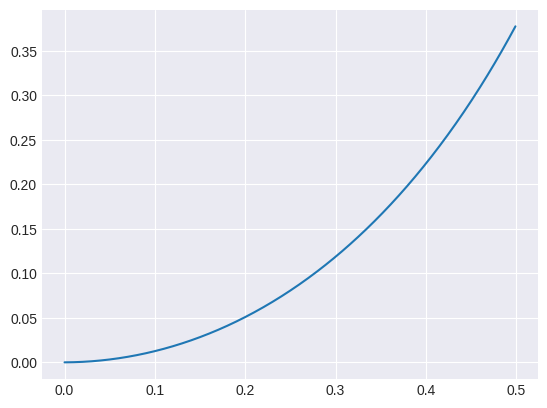

In [72]:
slise = 500
plt.plot(time_list[:slise], theta_list[:slise])
plt.show()